In [45]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import os
import argparse
from datetime import datetime
from sklearn.linear_model import LinearRegression


In [37]:
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
except Exception:
    YFINANCE_AVAILABLE = False

In [33]:
os.makedirs("output", exist_ok=True)

In [5]:
df=pl.read_csv("all_stocks_5yr.csv")

In [6]:
df.is_duplicated()


""
bool
false
false
false
false
false
…
false
false
false


In [7]:
df.describe()

statistic,date,open,high,low,close,volume,Name
str,str,f64,f64,f64,f64,f64,str
"""count""","""619040""",619029.0,619032.0,619032.0,619040.0,619040.0,"""619040"""
"""null_count""","""0""",11.0,8.0,8.0,0.0,0.0,"""0"""
"""mean""",null,83.023334,83.778311,82.256096,83.043763,4.3218e6,null
"""std""",null,97.378769,98.207519,96.507421,97.389748,8.6936e6,null
"""min""","""2013-02-08""",1.62,1.69,1.5,1.59,0.0,"""A"""
"""25%""",null,40.22,40.62,39.83,40.245,1.070325e6,null
"""50%""",null,62.59,63.15,62.02,62.62,2.082097e6,null
"""75%""",null,94.37,95.18,93.54,94.41,4.284507e6,null
"""max""","""2018-02-07""",2044.0,2067.99,2035.11,2049.0,6.1823763e8,"""ZTS"""


In [8]:
df.null_count()

date,open,high,low,close,volume,Name
u32,u32,u32,u32,u32,u32,u32
0,11,8,8,0,0,0


In [9]:
mean_val = df["open"].mean()   # eager scalar
df_mean = df.with_columns(
    df["open"].fill_null(mean_val).alias("open")
)


In [10]:
df.null_count()

date,open,high,low,close,volume,Name
u32,u32,u32,u32,u32,u32,u32
0,11,8,8,0,0,0


In [11]:
def align_and_clean(multi_df):
    if ('Close' in multi_df.columns.levels[0]) or ('Close' in [c[1] for c in multi_df.columns]):
        try:
            closes = multi_df.xs('Close', axis=1, level=1)
        except Exception:
            closes = multi_df.xs('Close', axis=1, level=0)
    else:
        if isinstance(multi_df.columns, pl.MultiIndex):
            closes = multi_df.loc[:, multi_df.columns.get_level_values(1) == 'Close']
        else:
            raise RuntimeError('Unable to locate Close column')
    closes = closes.sort_index()
    closes = closes.fillna(method='ffill').fillna(method='bfill')
    return closes


In [12]:
# Convert date column to true date type
df = df.with_columns([
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d")
])

In [13]:
df = df.sort("date")

In [14]:
# Forward-fill missing values for numeric columns
df = df.with_columns([
    pl.col(["open", "high", "low", "close", "volume"]).fill_null(strategy="forward")
])

In [15]:
df.head()

date,open,high,low,close,volume,Name
date,f64,f64,f64,f64,i64,str
2013-02-08,15.07,15.12,14.63,14.75,8407500,"""AAL"""
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,"""AAPL"""
2013-02-08,78.34,79.72,78.01,78.9,1298137,"""AAP"""
2013-02-08,36.37,36.42,35.825,36.25,13858795,"""ABBV"""
2013-02-08,46.52,46.895,46.46,46.89,1232802,"""ABC"""


In [16]:
df.describe()

statistic,date,open,high,low,close,volume,Name
str,str,f64,f64,f64,f64,f64,str
"""count""","""619040""",619040.0,619040.0,619040.0,619040.0,619040.0,"""619040"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""","""2015-08-18 00:48:23.494443""",83.02304,83.777891,82.255681,83.043763,4.3218e6,null
"""std""",null,97.37818,98.206971,96.506883,97.389748,8.6936e6,null
"""min""","""2013-02-08""",1.62,1.69,1.5,1.59,0.0,"""A"""
"""25%""","""2014-05-20""",40.22,40.62,39.83,40.245,1.070325e6,null
"""50%""","""2015-08-21""",62.59,63.15,62.02,62.62,2.082097e6,null
"""75%""","""2016-11-15""",94.37,95.18,93.535,94.41,4.284507e6,null
"""max""","""2018-02-07""",2044.0,2067.99,2035.11,2049.0,6.1823763e8,"""ZTS"""


In [38]:
df.unique()

date,open,high,low,close,volume,Name
date,f64,f64,f64,f64,i64,str
2017-01-12,281.94,284.23,280.16,283.54,649935,"""SHW"""
2013-10-11,89.05,90.29,88.5162,90.02,5335418,"""SLB"""
2016-06-01,53.47,53.87,53.255,53.3,2197249,"""ROST"""
2017-02-21,178.03,181.68,177.9,181.1,609909,"""AVB"""
2017-05-24,75.9,76.9,75.8,76.85,1718312,"""TEL"""
…,…,…,…,…,…,…
2016-11-04,108.59,108.81,107.73,107.79,763213,"""AON"""
2017-10-11,88.63,89.14,88.4594,88.8,907842,"""DPS"""
2016-04-15,60.24,60.6246,60.01,60.51,5965310,"""SBUX"""


In [39]:
# 2c. Fill nulls in all numeric columns (forward + backward)
numeric_cols = ["open", "high", "low", "close", "volume"]
df = df.with_columns([
    pl.col(numeric_cols)
      .fill_null(strategy="forward")  # forward fill
      .fill_null(strategy="backward") # backward fill
])

In [17]:
ticker = "AAPL"   # you can change to any symbol in the file

df_ticker = df.filter(pl.col("Name") == ticker)

df_ticker.head()

date,open,high,low,close,volume,Name
date,f64,f64,f64,f64,i64,str
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,"""AAPL"""
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,"""AAPL"""
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,"""AAPL"""
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,"""AAPL"""
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,"""AAPL"""


In [18]:
# Sort again to ensure correct order
df_ticker = df_ticker.sort("date")

In [19]:
df_ticker = df_ticker.with_columns([
    (pl.col("close") / pl.col("close").shift(1) - 1).alias("simple_return"),
    (pl.col("close").log() - pl.col("close").shift(1).log()).alias("log_return")
])

In [40]:
# 4b. Annualized volatility (was missing annualization factor)
df_ticker = df_ticker.with_columns([
    (pl.col("log_return").std() * np.sqrt(252)).alias("annualized_volatility")
])

In [41]:
# 4c. Rolling 21-day volatility
df_ticker = df_ticker.with_columns([
    pl.col("log_return").rolling_std(window_size=21, min_periods=1).alias("rolling_vol_21")
])

C:\Users\Admin\AppData\Local\Temp\ipykernel_12024\3976841970.py:3: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col("log_return").rolling_std(window_size=21, min_periods=1).alias("rolling_vol_21")


In [20]:
df_ticker.head()

date,open,high,low,close,volume,Name,simple_return,log_return
date,f64,f64,f64,f64,i64,str,f64,f64
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,"""AAPL""",null,null
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,"""AAPL""",0.010422,0.010368
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,"""AAPL""",-0.025067,-0.025386
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,"""AAPL""",-0.001903,-0.001905
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,"""AAPL""",-0.000899,-0.0009


In [21]:
# Annualized volatility using log returns
# Vol = std(log_returns) * sqrt(252)
df_ticker = df_ticker.with_columns([
    pl.col("log_return")
    .std()
    .alias("annualized_volatility")
])

In [22]:
# Rolling 21-day volatility
df_ticker = df_ticker.with_columns([
    pl.col("log_return")
    .rolling_std(window_size=21)
    .alias("rolling_vol_21")
])

In [24]:
df_ticker = df_ticker.drop("annualized_volatility")


In [27]:
#DRAWDOWNS
# -------------------------------------------------------------

# Running max price (highest close seen so far)
df_ticker = df_ticker.with_columns([
    pl.col("close").cum_max().alias("running_max")
])

In [28]:
# Drawdown = (Close - RunningMax) / RunningMax
df_ticker = df_ticker.with_columns([
    ((pl.col("close") - pl.col("running_max")) / pl.col("running_max")).alias("drawdown")
])

In [42]:
df_ticker = df_ticker.with_columns([
    pl.col("close").rolling_mean(window_size=20, min_periods=1).alias("sma20"),
    pl.col("close").rolling_mean(window_size=50, min_periods=1).alias("sma50")
])

C:\Users\Admin\AppData\Local\Temp\ipykernel_12024\704759815.py:2: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col("close").rolling_mean(window_size=20, min_periods=1).alias("sma20"),
C:\Users\Admin\AppData\Local\Temp\ipykernel_12024\704759815.py:3: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col("close").rolling_mean(window_size=50, min_periods=1).alias("sma50")


In [43]:
df_ticker = df_ticker.with_columns([
    (pl.col("sma20") > pl.col("sma50")).cast(pl.Int8).alias("trend_signal")
])

In [29]:
df_ticker.head()

date,open,high,low,close,volume,Name,simple_return,log_return,rolling_vol_21,running_max,drawdown
date,f64,f64,f64,f64,i64,str,f64,f64,f64,f64,f64
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,"""AAPL""",null,null,null,67.8542,0.0
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,"""AAPL""",0.010422,0.010368,null,68.5614,0.0
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,"""AAPL""",-0.025067,-0.025386,null,68.5614,-0.025067
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,"""AAPL""",-0.001903,-0.001905,null,68.5614,-0.026922
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,"""AAPL""",-0.000899,-0.0009,null,68.5614,-0.027797


In [30]:
# 7. TREND INDICATORS (20 & 50-DAY MOVING AVERAGES)
# -------------------------------------------------------------

df_ticker = df_ticker.with_columns([
    pl.col("close").rolling_mean(window_size=20).alias("sma20"),
    pl.col("close").rolling_mean(window_size=50).alias("sma50")
])

In [31]:
# Trend signal (1 = SMA20 > SMA50, 0 = otherwise)
df_ticker = df_ticker.with_columns([
    (pl.col("sma20") > pl.col("sma50")).cast(pl.Int8).alias("trend_signal")
])

In [44]:
dates = df_ticker["date"].to_list()
close = df_ticker["close"].to_list()
sma20 = df_ticker["sma20"].to_list()
sma50 = df_ticker["sma50"].to_list()
drawdown = df_ticker["drawdown"].to_list()
rolling_vol = df_ticker["rolling_vol_21"].to_list()

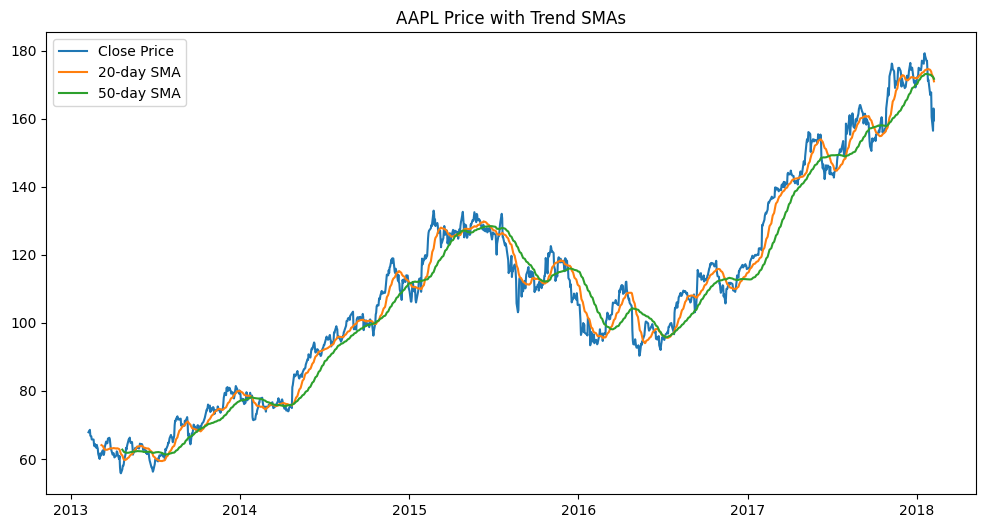

In [34]:
# 8. VISUALIZATION (MATPLOTLIB)
# -------------------------------------------------------------

plt.figure(figsize=(12,6))
plt.plot(df_ticker["date"], df_ticker["close"], label="Close Price")
plt.plot(df_ticker["date"], df_ticker["sma20"], label="20-day SMA")
plt.plot(df_ticker["date"], df_ticker["sma50"], label="50-day SMA")
plt.legend()
plt.title(f"{ticker} Price with Trend SMAs")
plt.savefig("output/price_trend.png")
plt.show()

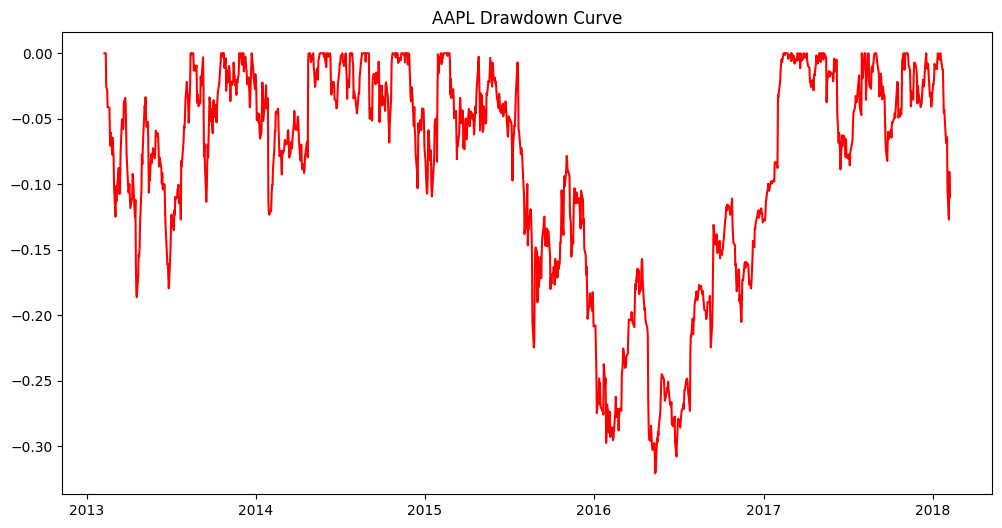

In [35]:
# Drawdown plot
plt.figure(figsize=(12,6))
plt.plot(df_ticker["date"], df_ticker["drawdown"], label="Drawdown", color="red")
plt.title(f"{ticker} Drawdown Curve")
plt.savefig("output/drawdown_curve.png")
plt.show()

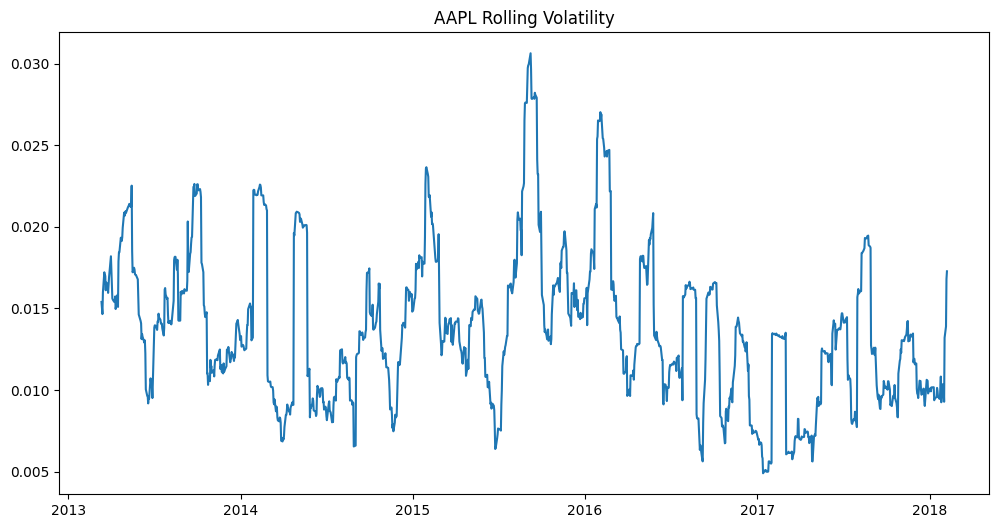

In [36]:
# Rolling Volatility
plt.figure(figsize=(12,6))
plt.plot(df_ticker["date"], df_ticker["rolling_vol_21"], label="21-day Volatility")
plt.title(f"{ticker} Rolling Volatility")
plt.savefig("output/rolling_vol.png")
plt.show()